# Custom Vision Object Detection

In [204]:
from azure.cognitiveservices.vision.customvision.training.training_api import TrainingApi
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
from azure.cognitiveservices.vision.customvision.prediction import PredictionEndpoint
import matplotlib.pyplot as plt
import json
import cv2

%matplotlib inline

config = json.load(open("config.json"))

## Get Project References

Instantiating the `TrainingApi` and `PredictionEndpoint` classes and passing in the appropriate keys. Using the `get_projects` method to get all projects and filter to get the project we want where we detect red or white wines.

In [205]:
train = TrainingApi(api_key=config["trainingKey"])

predict = PredictionEndpoint(api_key=config["predictionKey"])

In [7]:
projects = train.get_projects()

Accept header absent and forced to application/json


In [8]:
project = None

for p in projects:
    if p.name == "Red or White Wine":
        project = p

In [9]:
project.name

'Red or White Wine'

In [113]:
iterations = train.get_iterations(project.id)

Accept header absent and forced to application/json


### Define Methods

Some methods that we'll be using throughout the notebook:

- `add_boxes_to_images` - Calculates the rectangles to add to the images showing where it detected the wines and adds the tag name text.
- `show_inline_img` - Converts from `opencv` image to `matplotlib` so the image can be displayed in Jupyter.
- `append_predictions` - Gets predictions that is over a specified probability threshold.

In [199]:
def add_boxes_to_images(img, predictions):
    for pred in predictions:
        x = int(pred.bounding_box.left * img.shape[0])
        y = int(pred.bounding_box.top * img.shape[1])

        width = x + int(pred.bounding_box.width * img.shape[0])
        height = y + int(pred.bounding_box.height * img.shape[1])

        img = cv2.rectangle(img, (x, y), (width, height), (0, 0, 255), 2)

        img = cv2.putText(img, pred.tag_name, (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1, cv2.LINE_AA, False)

def show_inline_img(img):
    inline_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 20))
    plt.axis('off')
    
    plt.imshow(inline_img)

def append_predictions(result):
    predictions = []
    for prediction in result.predictions:
        if prediction.probability > 0.75:
            predictions.append(prediction)
            print(prediction.probability, prediction.tag_name)
            
    return predictions

## Predict with file on white wine

Uses an image on disk to call the custom vision service for prediction.

Read in the file with the "rb" mode to get the byte array of the image. Pass in the project ID, image data, and iteration ID.

In [233]:
with open("WHITE WINE GLASSES.jpg", mode="rb") as image_data:
    white_wine_result = predict.predict_image(project.id, image_data, iterations[0].id)

Accept header absent and forced to application/json


In [234]:
predictions = append_predictions(white_wine_result)

0.993455946 White
0.9913772 White


The result comes back with a bounding box object that gives us information of where it detected the object within the image.

In [17]:
print(predictions[0].bounding_box.as_dict())
print(predictions[1].bounding_box.as_dict())

{'left': 0.149535775, 'top': 0.01638028, 'width': 0.366552234, 'height': 0.5797825}
{'left': 0.48039788, 'top': 0.127492547, 'width': 0.3395564, 'height': 0.501807153}


Use `opencv` to read in the image and resize it.

In [235]:
img = cv2.imread("WHITE WINE GLASSES.jpg", cv2.IMREAD_COLOR)

In [236]:
img = cv2.resize(img, (400, 400))
img.shape

(400, 400, 3)

Original image.

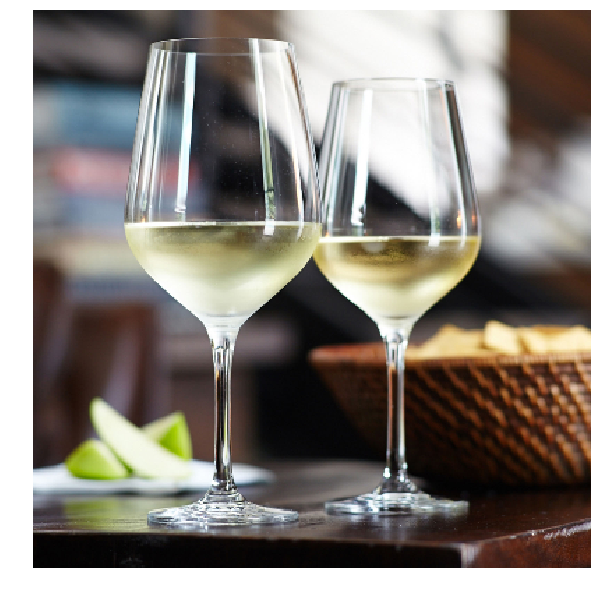

In [237]:
show_inline_img(img)

Add bounding boxes and text to image and show result.

You can see that the model predicted correctly that both wines are white and where they are located on the image.

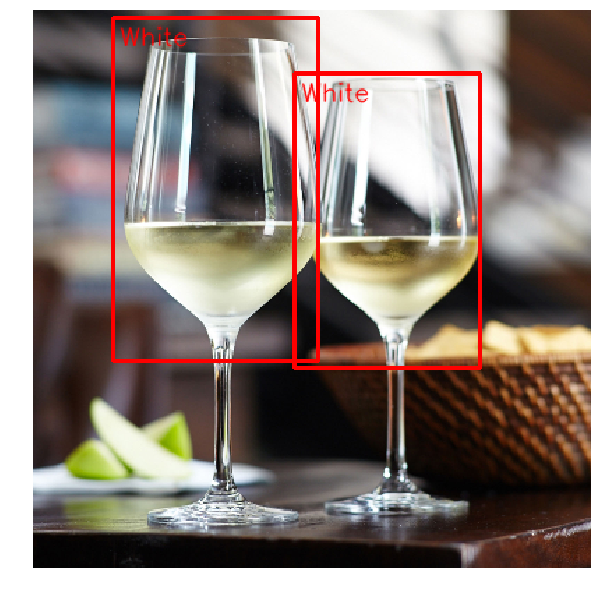

In [238]:
add_boxes_to_images(img, predictions)

show_inline_img(img)

## Predict via URL

Can also call the prediction endpoint by just using the URL of an image.

In [239]:
url_result = predict.predict_image_url(project.id,
    iterations[0].id,
    url="https://www.mklimited.co.uk/images/stories/virtuemart/product/Wine%20Pour_red_opt.jpg")

Accept header absent and forced to application/json


In [245]:
predictions = append_predictions(url_result)

0.886742 Red


In [243]:
img = cv2.imread("red-test.jpg", cv2.IMREAD_COLOR)

In [42]:
img.shape

(400, 400, 3)

Original image.

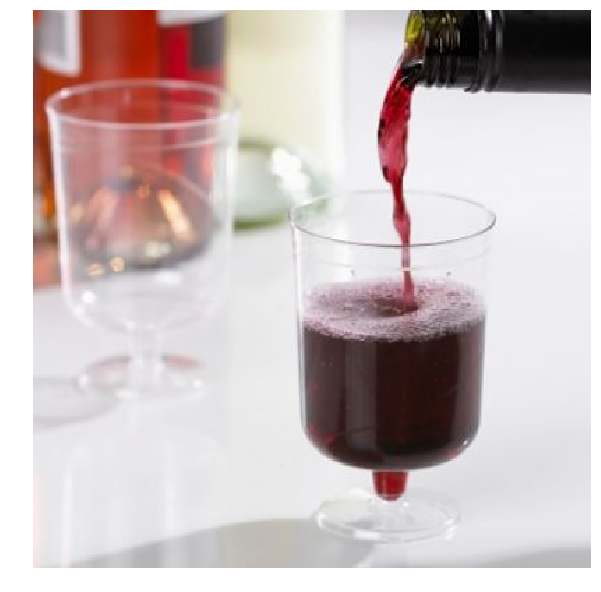

In [244]:
show_inline_img(img)

Image with bounding box and text appending to it. The model predicted correctly that this was red wine and where it is located on the image.

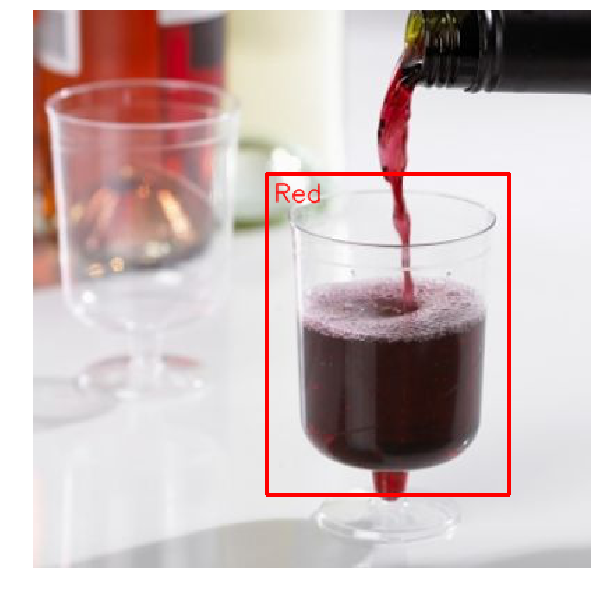

In [246]:
add_boxes_to_images(img, predictions)

show_inline_img(img)

## Predict with both wines in image

In [227]:
with open("red-and-white.jpg", mode="rb") as image_data:
    both_result = predict.predict_image(project.id, image_data, iterations[0].id)

Accept header absent and forced to application/json


In [228]:
predictions = append_predictions(both_result)

0.827656 Red
0.913324654 White
0.8850455 White


In [230]:
img = cv2.imread("red-and-white.jpg", cv2.IMREAD_COLOR)
img.shape

(313, 375, 3)

In [231]:
img = cv2.resize(img, (400, 400))

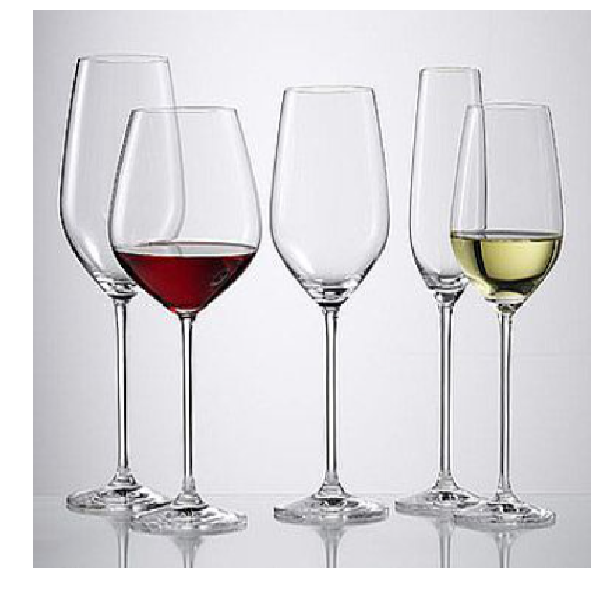

In [232]:
show_inline_img(img)

The model predicted correctly that the left wine is red and the right wine is white. However it thought that the middle glass was a glass with white wine with a high probability. While we still get correct results, more training is needed to prevent false positives.

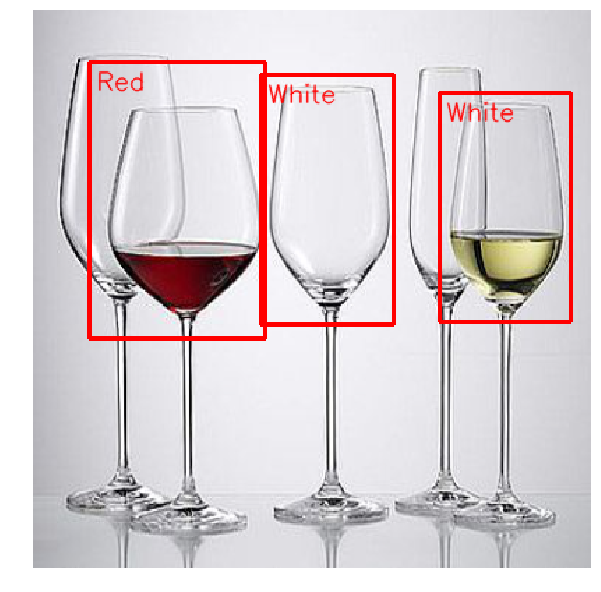

In [226]:
add_boxes_to_images(img, predictions)

show_inline_img(img)